In [34]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import sys
sys.path.append('../../')
from VisUtils import *
from split_data import *
from RF_Utils import *
from GPUtils import * 
# from GPUtils import DirichletGPModel
from sklearn.metrics import confusion_matrix
import itertools

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, PrecisionRecallDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotting Functions

In [2]:
def plot_heatmap(dist, observed_pred, probabilities, title): 
    pred_samples = dist.sample(torch.Size((100,))).exp()
    title = str(title)
    # probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
    probabilities_np = probabilities.numpy()
    class0_prob = probabilities_np[0, :]
    class1_prob = probabilities_np[1, :]
    
    num_samples = class0_prob.shape[0]
    side_length = int(np.ceil(np.sqrt(num_samples)))
    grid_data_class0 = np.full((side_length, side_length), np.nan)
    grid_data_class0.flat[:num_samples] = class0_prob
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[0].set_title('Probability of Class 0 - '+title)
    ax[0].axis('off');
    fig.colorbar(ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[0], label='Class 0')
    
    # Class 1
    grid_data_class1 = np.full((side_length, side_length), np.nan)
    grid_data_class1.flat[:num_samples] = class1_prob
    ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[1].set_title('Probability of Class 1 - '+title)
    ax[1].axis('off')
    fig.colorbar(ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[1], label='Class 1')
    fig.suptitle('nek2 generated probabilities from posterior distribution- '+title)
    # plt.savefig('nek2_probabilities_'+title+'.png')
    plt.show();

In [2]:
def plot_hist(observed_pred, title): 
    var = observed_pred.variance.numpy().tolist()
    # plot class 0 and class 1 sep
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    # class 0 
    
    sns.histplot(class0_var, bins=20, kde =True,color ='blue', ax=ax[0])
    # sns.kdeplot(class0_var, color='red', ax=ax[0])
    ax[0].set_title(f'Class 0 Variance Distribution')
    ax[0].set_xlabel('Variance')
    ax[0].set_ylabel('Density')
    ax[0].grid(True)

    # class 1
    sns.histplot(class1_var, bins=20, kde =True, color='green',ax=ax[1])
    # sns.kdeplot(class1_var, color='orange', ax=ax[1])
    ax[1].set_title(f'Class 1 Variance Distribution')
    ax[1].set_xlabel('Variance')
    ax[1].set_ylabel('Density')
    ax[1].grid(True)

    plt.suptitle('Distribution of Variances for Each Class -' + title)
    plt.legend()
    plt.grid(True) 
    plt.tight_layout()  
    plt.show();

In [3]:
def plot_variance_cm(observed_pred, true_labels, predictions, title):
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()
    var_fn = observed_pred.variance[0, true_neg].numpy()
    
    tp_var0 = class0_var[true_pos]
    tp_var1 = class1_var[true_pos]
    tn_var0 = class0_var[true_neg]
    tn_var1 = class1_var[true_neg]
    fp_var0 = class0_var[false_pos]
    fp_var1 = class1_var[false_pos]
    fn_var0 = class0_var[false_neg]
    fn_var1 = class1_var[false_neg]

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    sns.heatmap([tp_var0, tp_var1], cmap='RdYlBu_r', ax=ax[0, 0])
    ax[0, 0].set_title('True Positives')

    sns.heatmap([tn_var0, tn_var1], cmap='RdYlBu_r', ax=ax[0, 1])
    ax[1, 1].set_title('True Negatives')

    sns.heatmap([fp_var0, fp_var1], cmap='RdYlBu_r', ax=ax[1, 0])
    ax[0, 1].set_title('False Positives')

    sns.heatmap([fn_var0, fn_var1], cmap='RdYlBu_r', ax=ax[1, 1])
    ax[1, 0].set_title('False Negatives')

    plt.suptitle('NEK2 Binding Predictions: Sample Variance - ' + title)
    plt.tight_layout()
    plt.savefig(f'NEK2_bind_heatmap_cm_{title}.png')
    plt.show();

In [4]:
def plot_hist_tp_tn(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()

    plt.figure(figsize=(10,6))
    plt.hist(var_tp, bins=10, alpha=0.5, density=True, label = 'True Positive')
    plt.hist(var_tn, bins=10, alpha=0.5, density=True, label = 'True negative')
    plt.xlabel('Variance')
    plt.legend()
    plt.ylabel('Density')
    plt.title(f'Variance Distribution for TP and TN - {title}')
    plt.grid(True)
    plt.show();

In [5]:
def plot_cm_dist(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    plt.hist(var_tp, color='green', alpha=0.7)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    

    plt.subplot(2, 2, 2)
    plt.hist(var_fp, color='red', alpha=0.7)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    plt.hist(var_fn, color='orange', alpha=0.7)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    plt.hist(var_tn, color='blue', alpha=0.7)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'Variance Distribution of Predictions {title}', fontsize=14, y=1.05)
    plt.show();

In [6]:
def plot_cm_dist_kde(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    # print(f'predictions shape: {predictions.shape}')
    # print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    # to add same scale
    # bins = np.linspace(0, max(max(var_tp), max(var_tn), max(var_fp), max(var_fn)), 50) 
    plt.subplot(2, 2, 4)
    sns.histplot(var_tp, kde=True,color='green', bins=10)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    sns.histplot(var_tn, kde=True,color='blue', bins=10)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 2)
    sns.histplot(var_fp, kde=True,color='red', bins=10)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    sns.histplot(var_fn, kde=True, color='orange', bins=10)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'Variance Distribution of Predictions {title}', fontsize=14, y=1.05)

    plt.show();

In [7]:
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true, y_prob):
    y_prob0 = y_prob[0,:]
    y_prob1 = y_prob[1,:]
    fpr0, tpr0, thresholds0 = roc_curve(y_true, y_prob0)
    fpr1, tpr1, thresholds1 = roc_curve(y_true, y_prob1)
    roc_auc0 = auc(fpr0, tpr0)
    roc_auc1 = auc(fpr1, tpr1)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='orange', lw=2, label='class 1 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot(fpr0, tpr0, color='blue', lw=2, label='class 0 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NEK2 ROC Curve')
    plt.legend()
    plt.show(); 


In [9]:
# split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
# file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
# all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

In [10]:
# # SMOTE: Adjust imbalanced training data

# # transform the dataset
# oversample = SMOTE()
# new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

# # display(new_train_x_df.head)

# # display("original training size: ",train_x_df_temp.shape)
# # display(train_y_df_temp.value_counts())
# # display("SMOTE train set size:",new_train_x_df.shape)
# # display(new_train_y_df.value_counts())

# # SMOTE 


In [11]:
# Transform data to PyTorch tensors

# Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()

# Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_scaled_data = scaling.transform(train_x_df)
# test_scaled_data = scaling.transform(test_x_df) 

split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib/'
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv

train_x_df_temp = pd.read_csv(split_path+"inhib_train_x_SMOTE.csv",header=None)
train_y_df_temp = pd.read_csv(split_path+"inhib_train_y_SMOTE.csv",header=None)
test_x_df = pd.read_csv(split_path+"inhib_test_x_SMOTE.csv",header=None)
test_y_df = pd.read_csv(split_path+"inhib_test_y_SMOTE.csv",header=None)

train_x_temp = train_x_df_temp.to_numpy().astype("long")
test_x_temp = test_x_df.to_numpy().astype("long")

train_y_temp = train_y_df_temp.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 

torch.Size([3046, 306])
torch.Size([3046])


In [12]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 


    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # output distribution
            pred_means = dist.loc          # means of distributino 
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions mean and var  
            # class_pred = self.model(input).loc.max(0)[1].numpy()  # predictions (0 or 1) 
            class_pred = self.model(input).loc.max(0)[1]
            
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy()
        
        return y_pred

    def gp_results(self, x_input, y_true, plot_title): 
        y_pred = self.evaluate(x_input, y_true) 
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.numpy().reshape(-1)
        # cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(y_true, y_pred, ['0','1'], title=plot_title)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x_input)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist  

        recall = recall_score(y_true, y_pred)
        tp, tn, fp, fn = calculate_metrics(y_true, y_pred) 
        sensitivity = tp / (tp + fn) 
        specificity = tn / (tn + fp) 
        print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, sensitivity: {sensitivity:.4f}, specificity: {specificity:.4f}')
        return {'accuracy': accuracy, 'precision': precision,  'recall':recall, 'sensitivity':sensitivity, 'specificity':specificity}

       

In [13]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.031   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.744   lengthscale: 1.321   noise: 1.286
Iter 21/300 - Loss: 5.008   lengthscale: 2.200   noise: 1.812
Iter 31/300 - Loss: 4.492   lengthscale: 3.277   noise: 1.832
Iter 41/300 - Loss: 4.143   lengthscale: 4.336   noise: 1.345
Iter 51/300 - Loss: 3.898   lengthscale: 5.184   noise: 0.736
Iter 61/300 - Loss: 3.740   lengthscale: 5.802   noise: 0.327
Iter 71/300 - Loss: 3.651   lengthscale: 6.245   noise: 0.148
Iter 81/300 - Loss: 3.600   lengthscale: 6.565   noise: 0.082
Iter 91/300 - Loss: 3.586   lengthscale: 6.795   noise: 0.055
Iter 101/300 - Loss: 3.576   lengthscale: 6.959   noise: 0.041
Iter 111/300 - Loss: 3.559   lengthscale: 7.076   noise: 0.033
Iter 121/300 - Loss: 3.558   lengthscale: 7.161   noise: 0.028
Iter 131/300 - Loss: 3.551   lengthscale: 7.228   noise: 0.024
Iter 141/300 - Loss: 3.546   lengthscale: 7.284   noise: 0.021
Iter 151/300 - Loss: 3.548   lengthscale: 7.330   noise: 0.019
Ite

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


accuracy: 0.9977, precision: 0.9954, recall: 1.0000, sensitivity: 1.0000, specificity: 0.9954
accuracy: 0.9487, precision: 0.6667, recall: 0.5000, sensitivity: 0.5000, specificity: 0.9816


<Figure size 600x400 with 0 Axes>

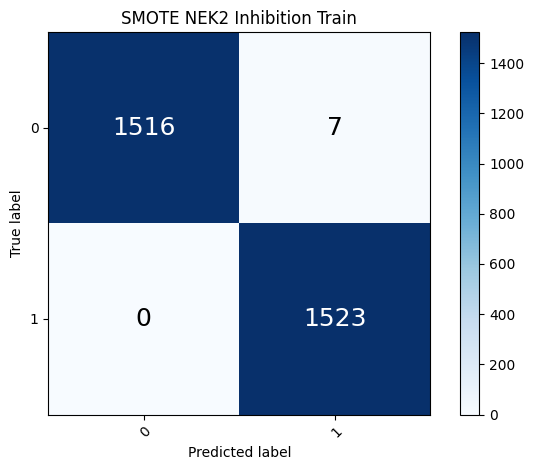

<Figure size 600x400 with 0 Axes>

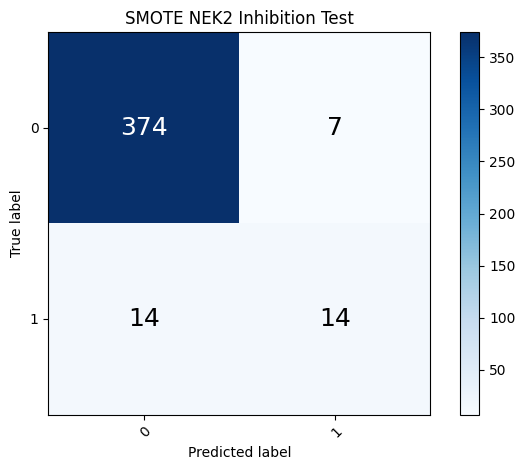

In [14]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
train_results1 = trainer1.gp_results(train_x, train_y, 'SMOTE NEK2 Inhibition Train')

test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)
test_results1 = trainer1.gp_results(test_x, test_y, 'SMOTE NEK2 Inhibition Test')


# Probabilities and Variance 

In [15]:
# train_pred = train_observed_pred
train_observed_pred.mean.numpy()
train_pred_variance2D = train_observed_pred.variance.numpy()
# test_pred = test_observed_pred
test_observed_pred.mean.numpy()
test_pred_variance2D=test_observed_pred.variance.numpy()
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
var_min, var_max
# train_observed_pred.variance.numpy()
# test_observed_pred.variance.numpy()

(0.7143857, 4.248365)

In [16]:

train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
train_prob_stds = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).std(0)
train_prob_stds.shape

lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
prob_stds = (pred_samples / pred_samples.sum(-2, keepdim=True)).std(0)


In [17]:
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()
train_perf_df['mean_pred_class0'] = train_observed_pred.mean.numpy()[0,]
train_perf_df['mean_pred_class1'] = train_observed_pred.mean.numpy()[1,]
train_perf_df['y'] = train_y
train_perf_df['y_pred'] = train_pred_means.max(0)[1]
train_perf_df['var_pred_class0']=train_observed_pred.variance.numpy()[0,]
train_perf_df['var_pred_class1']=train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_prob_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_prob_class1'] = train_probabilities.numpy()[1,]
train_perf_df['pred_prob_std_class0'] = train_prob_stds.numpy()[0,]
train_perf_df['pred_prob_std_class1'] = train_prob_stds.numpy()[1,]

test_perf_df['mean_pred_class0'] = test_observed_pred.mean.numpy()[0,]
test_perf_df['mean_pred_class1'] = test_observed_pred.mean.numpy()[1,]
test_perf_df['y'] = test_y
test_perf_df['y_pred'] = test_pred_means.max(0)[1]
test_perf_df['var_pred_class0']=test_observed_pred.variance.numpy()[0,]
test_perf_df['var_pred_class1']=test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_prob_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_prob_class1'] = probabilities.numpy()[1,]
test_perf_df['pred_prob_std_class0'] = prob_stds.numpy()[0,]
test_perf_df['pred_prob_std_class1'] = prob_stds.numpy()[1,]

train_perf_df.to_csv("model_performance/NEK2_inhib_SMOTE_train_perf.csv", index=False)
test_perf_df.to_csv("model_performance/NEK2_inhib_SMOTE_test_perf.csv", index=False)

In [133]:
# get train samples 

# TRAIN
# plot_heatmap(train_dist, train_observed_pred, train_probabilities, 'train')

In [27]:
# TEST SET
# # Get confidence regions 
# confidence 
# plot_heatmap(test_dist, test_observed_pred, probabilities, 'test')

In [44]:
# plot_hist(train_observed_pred, 'train')
# plot_hist(test_observed_pred, 'test')

# plot_cm_dist_kde(test_observed_pred, test_pred, test_y, 'Binding, test')

In [45]:
# plot_cm_dist(train_observed_pred, train_pred, train_y, 'train')
# plot_cm_dist(test_observed_pred, test_pred, test_y, 'test')


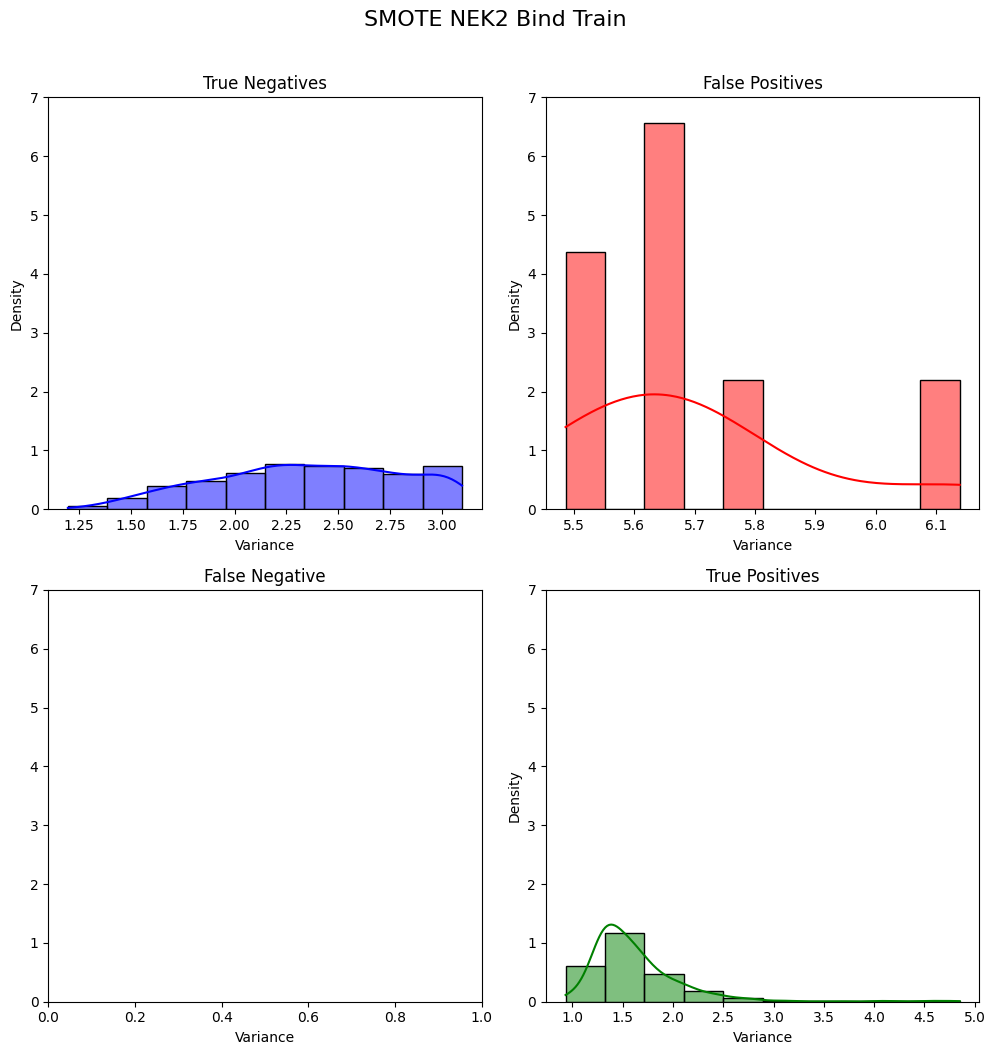

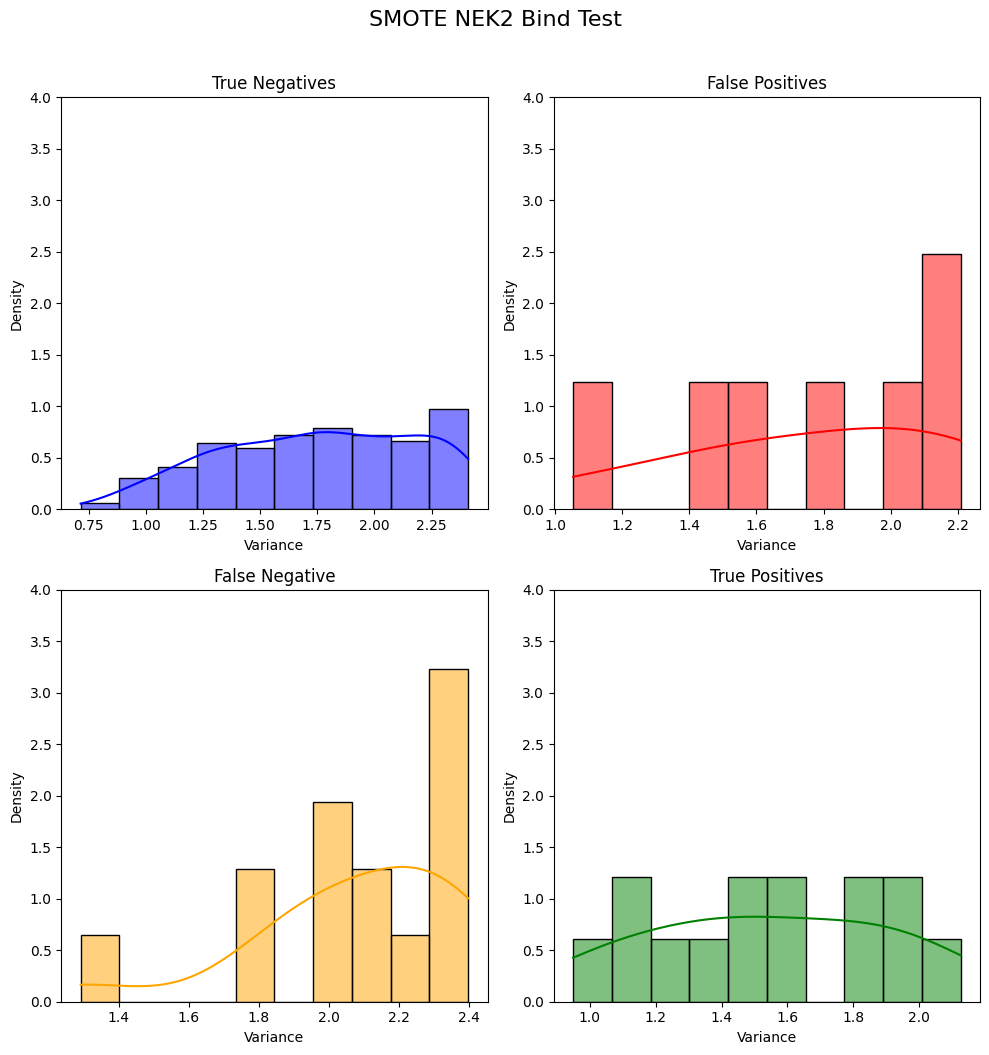

In [21]:
plot_cm_dist_kdedensity(train_observed_pred, train_pred, train_y, 'SMOTE NEK2 Bind Train',7)
plot_cm_dist_kdedensity(test_observed_pred, test_pred, test_y, 'SMOTE NEK2 Bind Test',4)

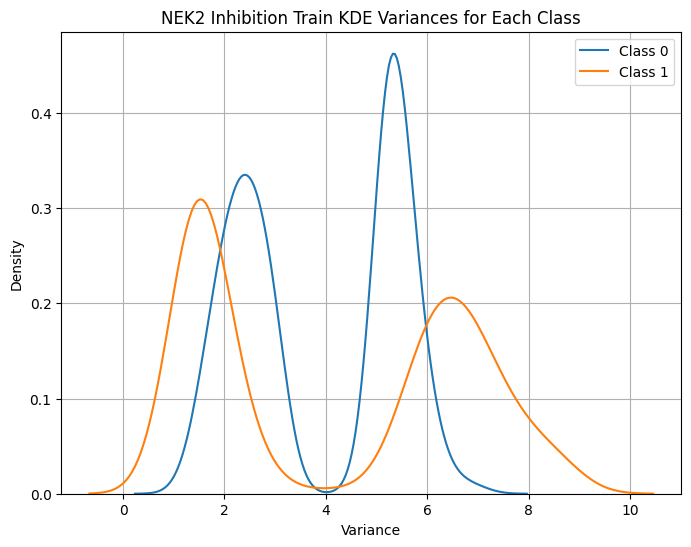

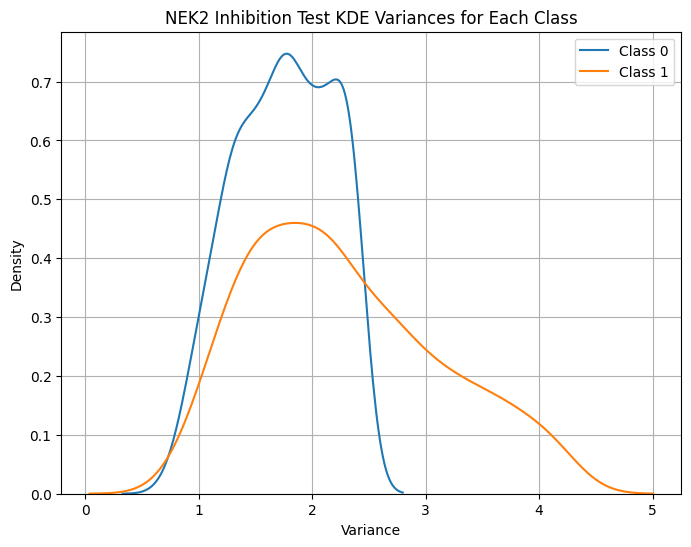

In [35]:
plot_kde(train_observed_pred, 'NEK2 Inhibition Train')
plot_kde(test_observed_pred, 'NEK2 Inhibition Test')
# plot_hist(test_observed_prt')


In [95]:
# plot_roc(test_y, probabilities)

In [23]:
def plot_prec_recall(true_labels, probabilities_class1, title):
    precision, recall, thresholds = precision_recall_curve(true_labels, probabilities_class1)
    plt.figure(figsize=(8,6))
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot()
    plt.title(title)
    plt.show();


<Figure size 800x600 with 0 Axes>

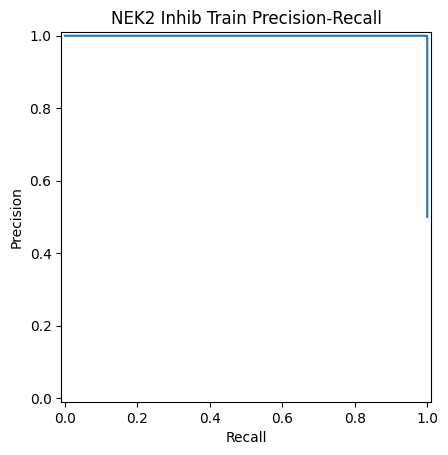

<Figure size 800x600 with 0 Axes>

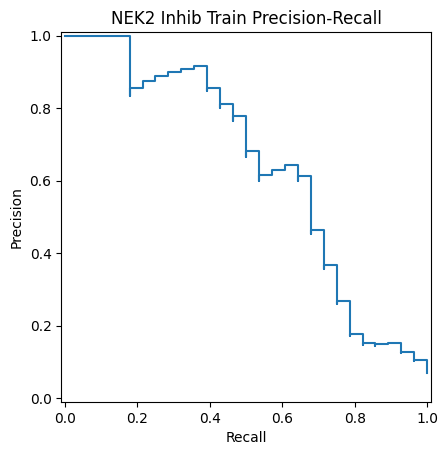

In [24]:
plot_prec_recall(train_y, train_probabilities.numpy()[1,:], 'NEK2 Inhib Train Precision-Recall')
plot_prec_recall(test_y, probabilities.numpy()[1,:],'NEK2 Inhib Train Precision-Recall')

In [25]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]

(2, 409)


In [26]:
probabilities.numpy()[1,].shape

(409,)

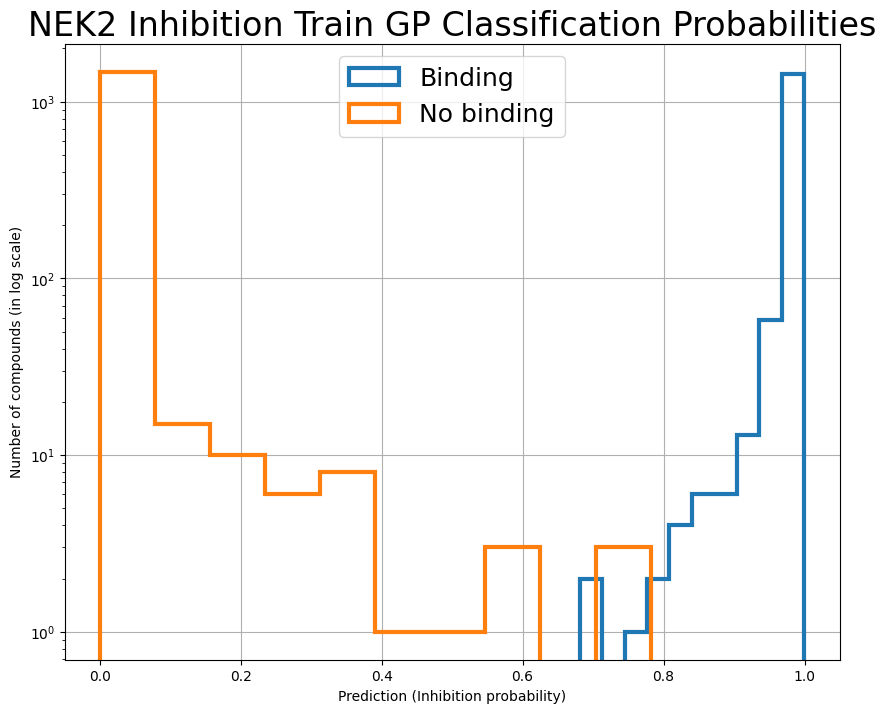

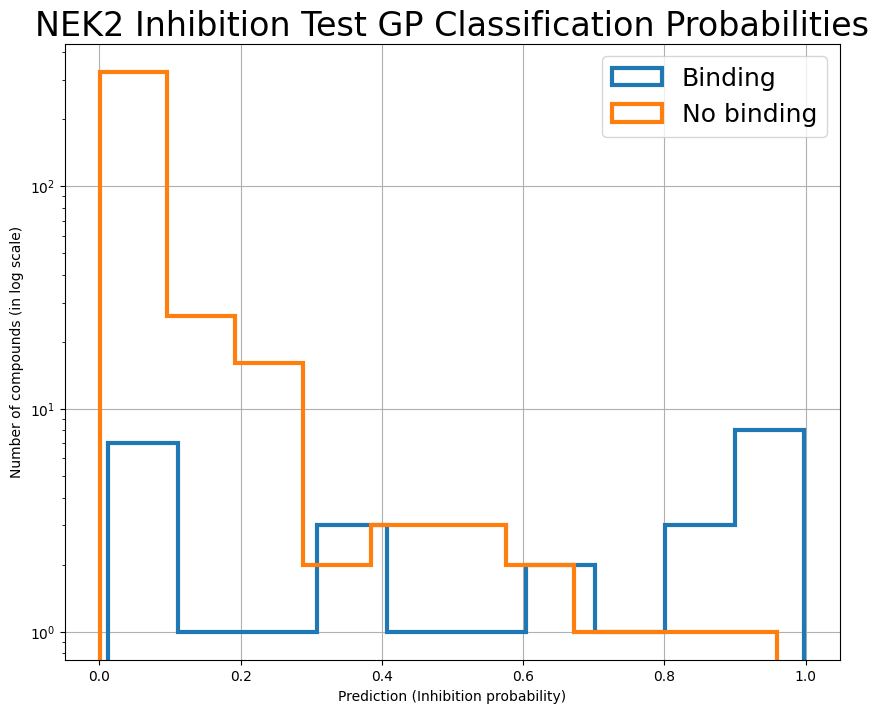

In [27]:

plot_prob_hist(train_probabilities, train_y, 'NEK2 Inhibition Train GP Classification Probabilities', 'Inhibition')
plot_prob_hist(probabilities, test_y, 'NEK2 Inhibition Test GP Classification Probabilities', 'Inhibition')

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 62.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 60.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

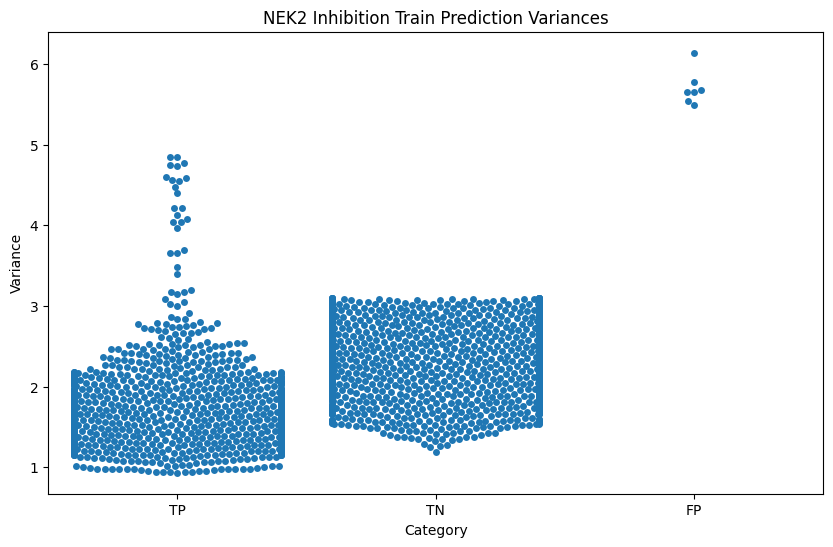

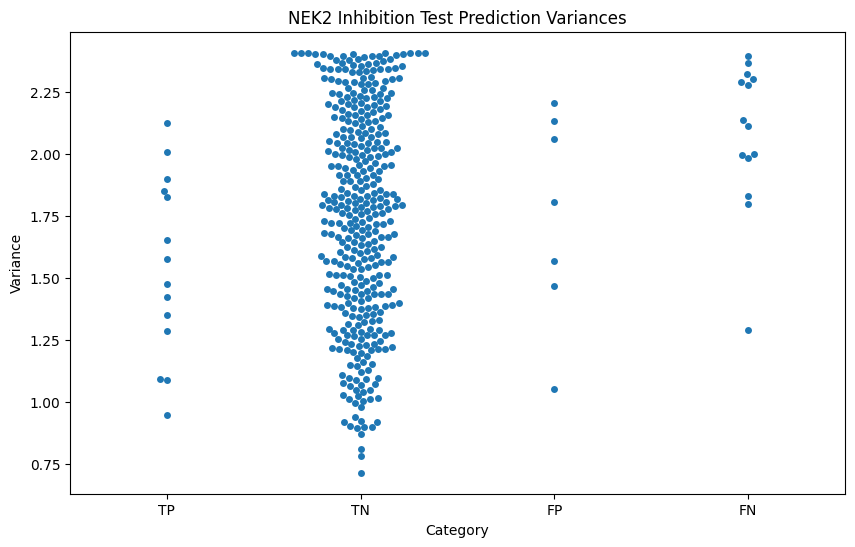

In [29]:
plot_swarmplot(train_pred, train_y, train_observed_pred,'NEK2 Inhibition Train Prediction Variances')
plot_swarmplot(test_pred, test_y, test_observed_pred,'NEK2 Inhibition Test Prediction Variances')

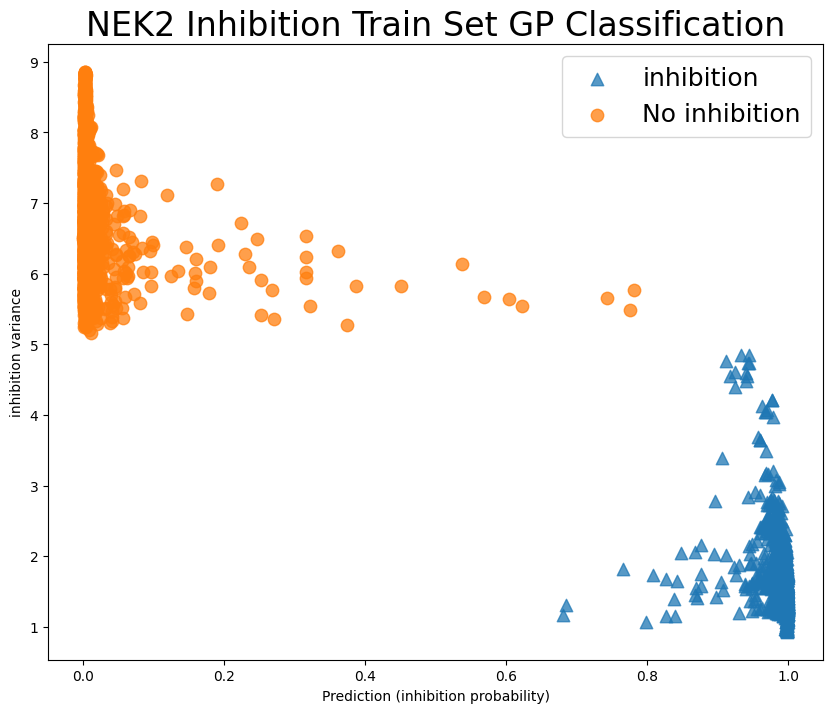

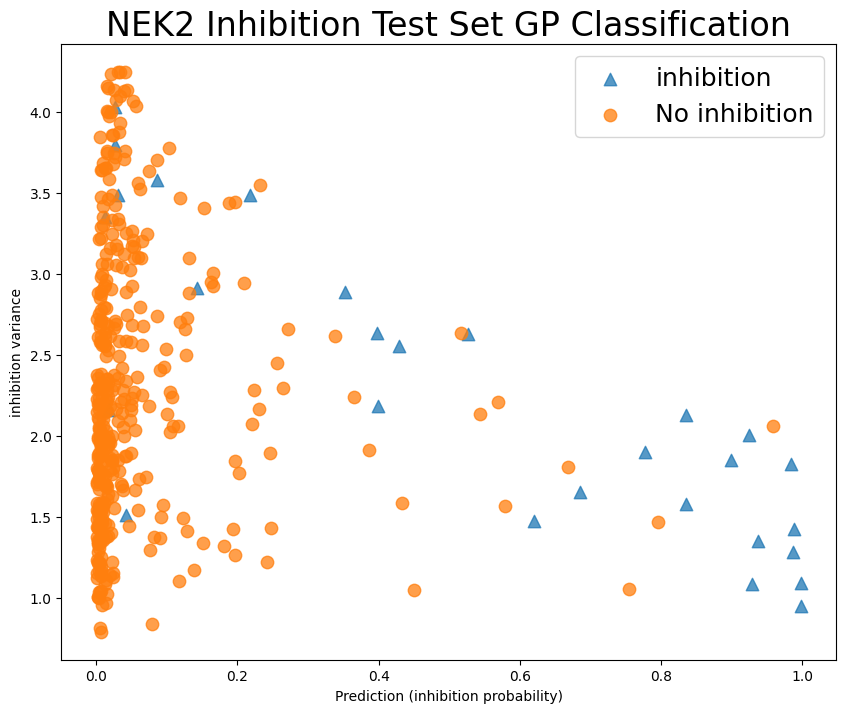

In [32]:
probabilities_vs_var(train_y, train_probabilities, train_observed_pred,'NEK2 Inhibition Train Set GP Classification', 'inhibition')
probabilities_vs_var(test_y, probabilities, test_observed_pred,'NEK2 Inhibition Test Set GP Classification', 'inhibition')

In [87]:
# indices0 = np.where(test_pred == 0)[0]
# indices1 = np.where(test_pred == 1)[0]

# var_class0 = test_observed_pred.variance[0].numpy()
# var_class1 = test_observed_pred.variance[1].numpy()
# plt.errorbar(indices0, test_pred[indices0], 
#              xerr=var_class0[indices0], fmt='o', label='Class 0')

# plt.errorbar(indices1, test_pred[indices1], 
#              xerr=var_class1[indices1], fmt='o', label='Class 1')


# plt.xlabel('Predictions')
# plt.yticks([0, 1], ['0', '1'])
# plt.title('Prediction variances')
# plt.legend()
# plt.show()

In [83]:
# dist = trainer1.model(test_x)
# pred_varainces = dist.variance
# normalized = pred_varainces/pred_varainces.max() 
# normalized.shape
# plt.figure(figsize=(8, 6))
# plt.imshow(normalized.detach().numpy(), cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Confidence Score')
# plt.title('Confidence Heatmap')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

In [96]:
# plot_variance_cm(test_observed_pred, test_y.numpy(), test_pred, 'test')

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_76812/2154121388.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


NameError: name 'var_min' is not defined

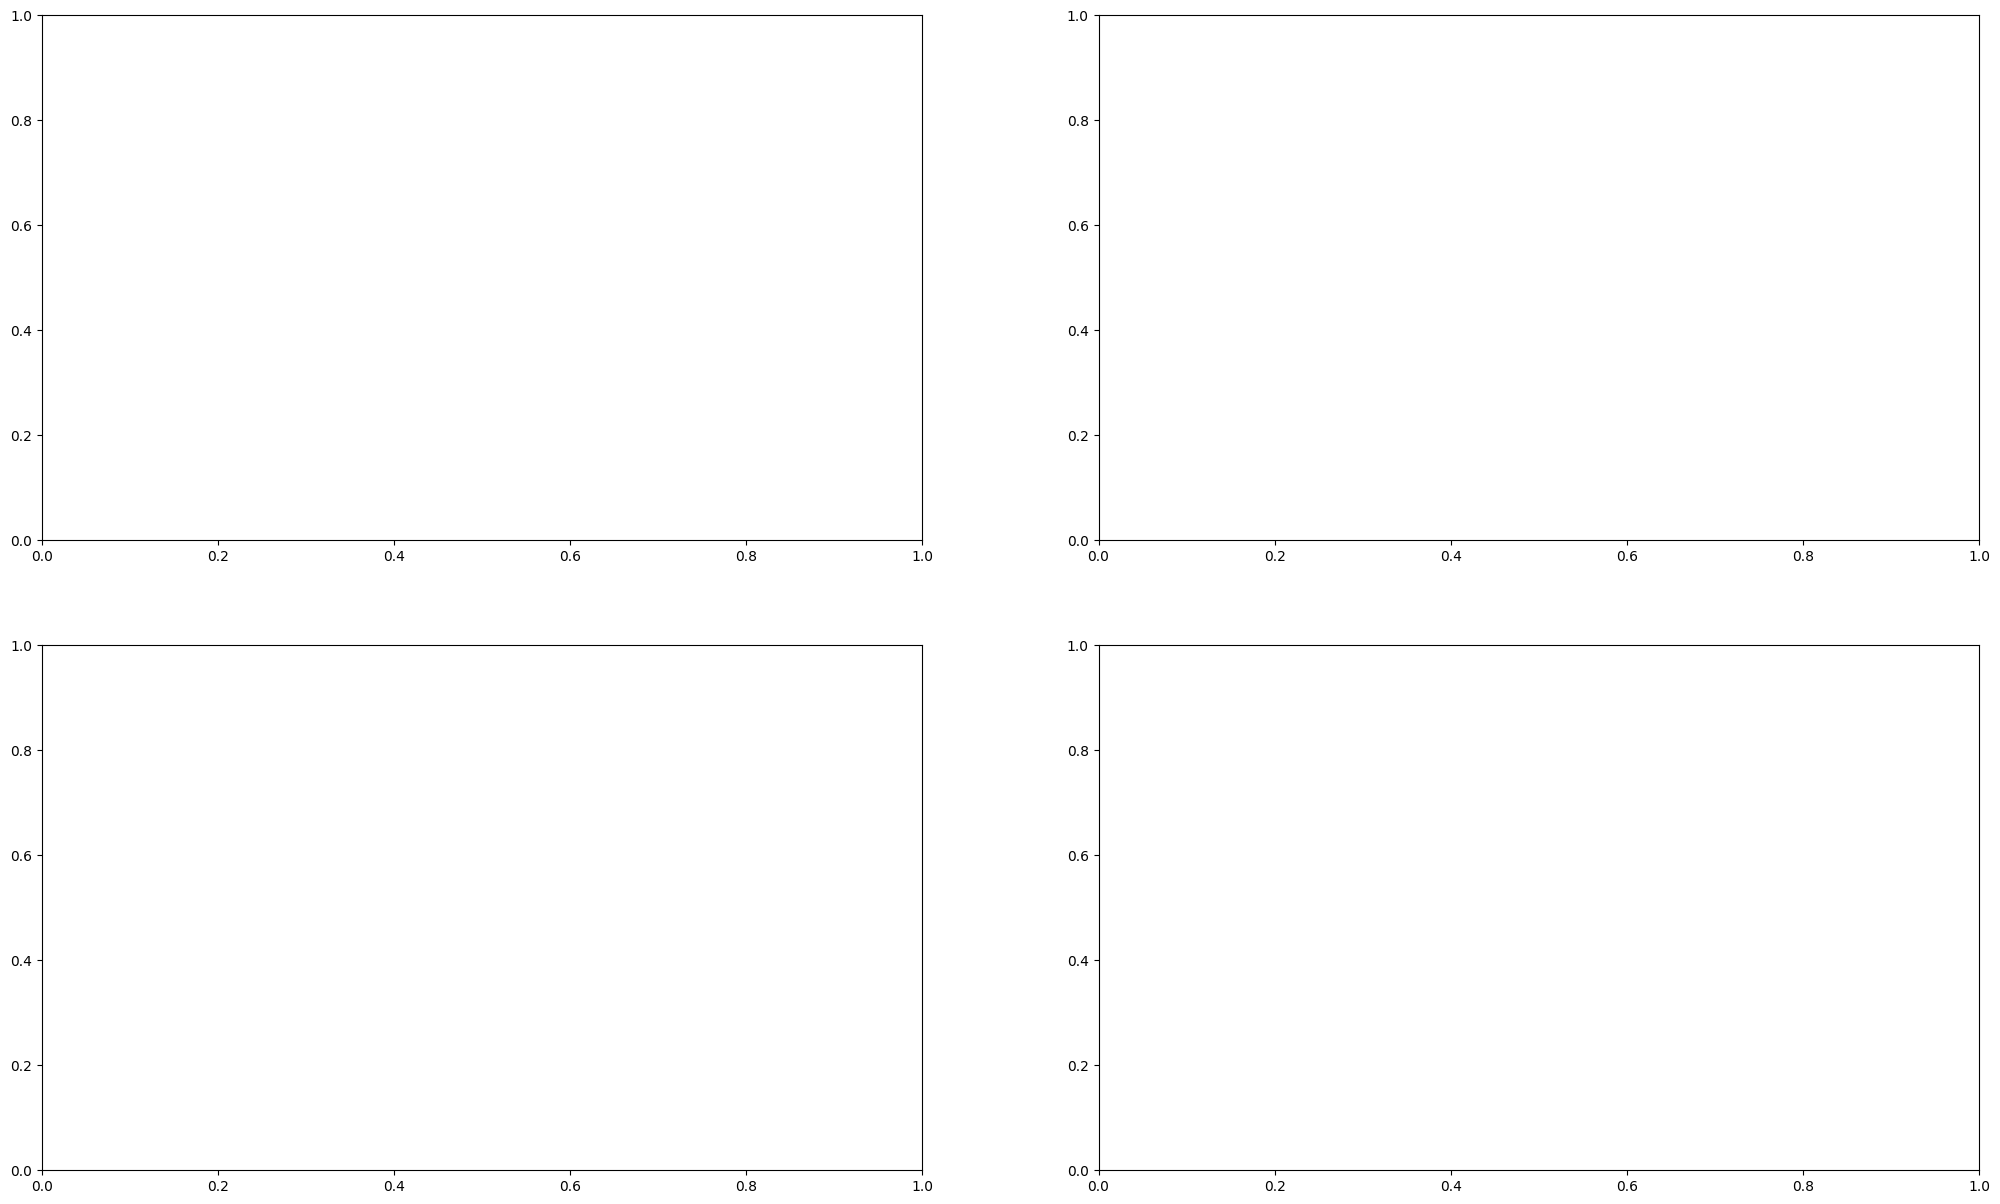

In [100]:
marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig, ax = plt.subplots(2, 2, figsize=(25, 15))
true_labels = test_y.numpy()


true_pos = np.where((test_pred == 1) & (true_labels == 1))[0] 
true_neg = np.where((test_pred == 0) & (true_labels == 0))[0]
false_pos = np.where((test_pred == 1) & (true_labels == 0))[0] 
false_neg = np.where((test_pred == 0) & (true_labels == 1))[0] 

var_tp = test_observed_pred.variance[1, true_pos].numpy()
var_tn = test_observed_pred.variance[0, true_neg].numpy()
var_fp = test_observed_pred.variance[1, false_pos].numpy()
var_fn = test_observed_pred.variance[0, false_neg].numpy()

sc_tp = ax[0, 0].scatter(true_pos, (test_y[true_pos] - test_pred[true_pos]), c=test_pred_variance2D[1, true_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[0])
ax[0, 0].set_title('True Positives')
ax[0, 0].set_xlabel('Data index')
ax[0, 0].set_ylabel('Actual - Predicted')


sc_tn = ax[0, 1].scatter(true_neg, (test_y[true_neg] - test_pred[true_neg]), c=test_pred_variance2D[1, true_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[1])
ax[0, 1].set_title('True Negatives')
ax[0, 1].set_xlabel('Data index')
ax[0, 1].set_ylabel('Actual - Predicted')


sc_fp = ax[1, 0].scatter(false_pos, (test_y[false_pos] - test_pred[false_pos]), c=test_pred_variance2D[1, false_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[2])
ax[1, 0].set_title('False Positives')
ax[1, 0].set_xlabel('Data index')
ax[1, 0].set_ylabel('Actual - Predicted')


sc_fn = ax[1, 1].scatter(false_neg, (test_y[false_neg] - test_pred[false_neg]), c=test_pred_variance2D[1, false_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[3])
ax[1, 1].set_title('False Negatives')
ax[1, 1].set_xlabel('Data index')
ax[1, 1].set_ylabel('Actual - Predicted')

cbar_tp = fig.colorbar(sc_tp, ax=ax[0, 0], location='right')
cbar_tp.set_label('Variance', fontsize=16)

cbar_tn = fig.colorbar(sc_tn, ax=ax[0, 1], location='right')
cbar_tn.set_label('Variance', fontsize=16)

cbar_fp = fig.colorbar(sc_fp, ax=ax[1, 0], location='right')
cbar_fp.set_label('Variance', fontsize=16)

cbar_fn = fig.colorbar(sc_fn, ax=ax[1, 1], location='right')
cbar_fn.set_label('Variance', fontsize=16)

plt.tight_layout()
plt.show()
# cbar.set_label('Variance', fontsize=16)

plt.tight_layout()
# plt.savefig(f'nek2_binding_scatter_dist_test.png')
plt.show()

In [ ]:
# calibratio
from sklearn.calibration import calibration_curve
# n_bins = 10
# prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Plot')
# plt.grid(True)
# plt.show(); 


In [98]:
# levels = np.linspace(0, 3, 11)
# plt.figure(figsize=(8, 6))

# x_values = test_x[:, 0].numpy()
# y_values = test_y.numpy()
# # y = np.linspace(test_y.min(), test_y.max(), 283)
# x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# for class_idx in range(2):
#     plt.subplot(1, 2, class_idx + 1)
#     pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
#     # print(pred_var_copy)
#     # pred_var_reshaped = pred_var_copy.reshape((2, 283, 283))
#     # plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

#     pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
#     # pred_var_copy = np.repeat(pred_var_copy[:, :, np.newaxis], x_mesh.shape[1], axis=2)
#     print(pred_var_copy.shape)
#     print(pred_var_copy)
#     plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

#     plt.colorbar(label='Variance')
#     plt.xlabel('X axis')
#     plt.ylabel('Y axis')
#     plt.title(f'Class {class_idx} Variance')


# plt.tight_layout()
# plt.show();


In [99]:
# samples = np.arange(len(test_x))
# vars_class0 = test_pred_variance2D[0]
# vars_class1 = test_pred_variance2D[1]

# plt.figure(figsize=(8, 6))
# plt.hexbin(samples, vars_class0, gridsize=50, cmap='tab20', label='Class 0')
# plt.hexbin(samples, vars_class1, gridsize=50, cmap='tab20', label='Class 1')
# plt.colorbar(label='Density')
# plt.xlabel('Samples')
# plt.ylabel('Variances')
# plt.legend()
# plt.show()


In [ ]:
pred_var[1].shape

In [ ]:
class_0_variances = pred_var[0]
class_1_variances = pred_var[1]

x_min, x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
y_min, y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

print(xx.shape, yy.shape)
plt.figure()
plt.contourf(xx, yy, np.sqrt(pred_var[0].reshape(xx.shape)), alpha=0.8)
plt.contourf(xx, yy, np.sqrt(pred_var[1].reshape(xx.shape)), alpha=0.8)
plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Contour Plot with Variances')
plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/342155008.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')


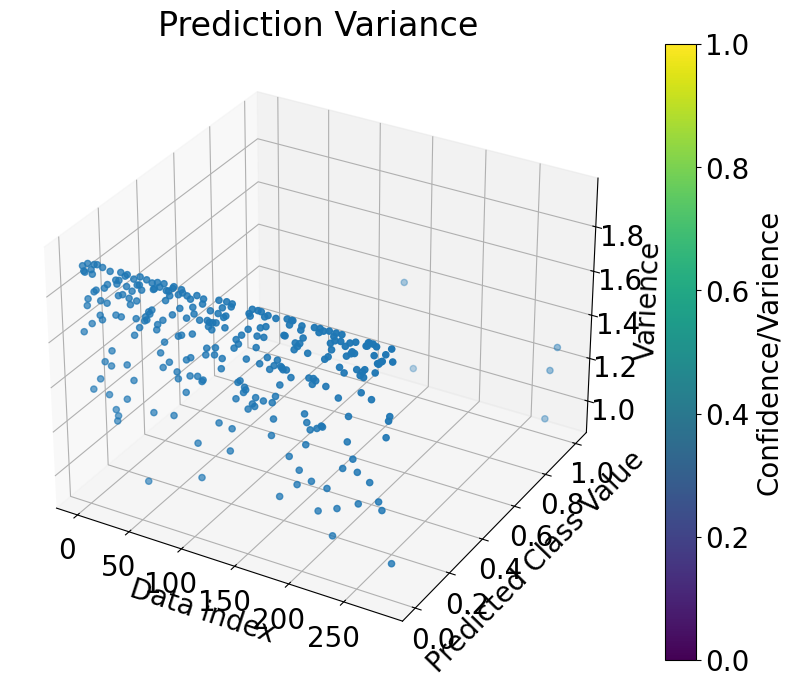

In [149]:
# scatter 3d? 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Varience')

ax.set_xlabel('Data index')
ax.set_ylabel('Predicted Class Value')
ax.set_zlabel('Varience')
ax.set_title('Prediction Variance')
plt.show();


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/1138995925.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


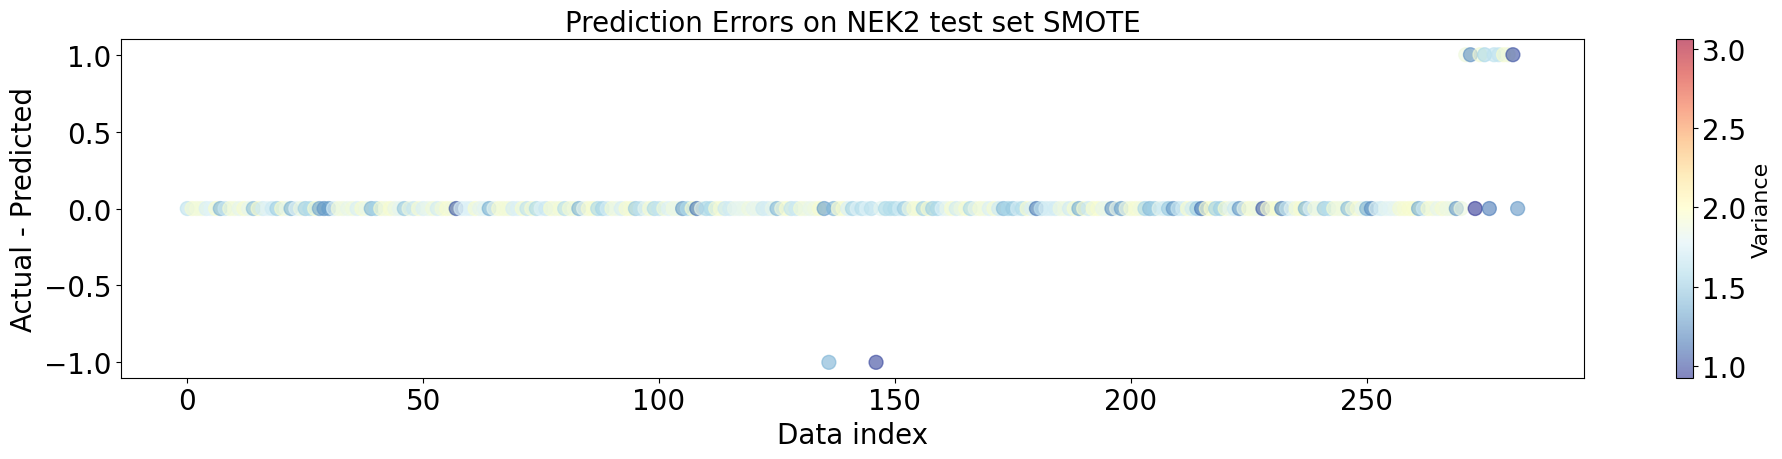

In [87]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/3513342963.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


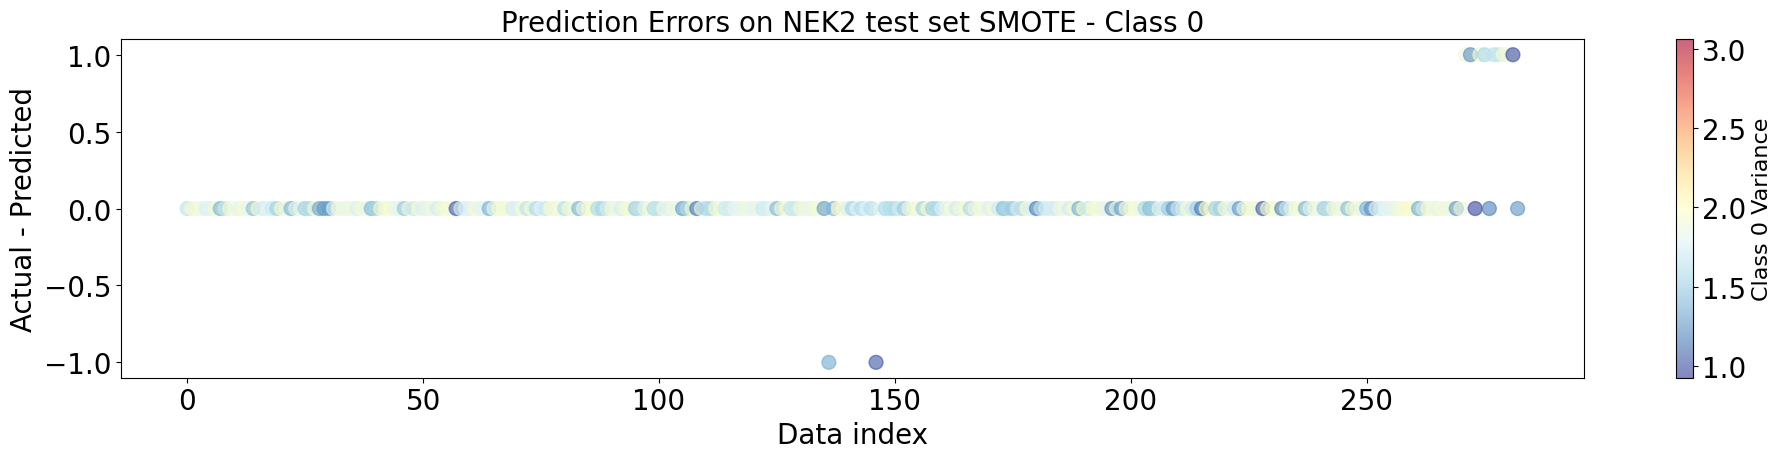

In [86]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 0",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/3654803106.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


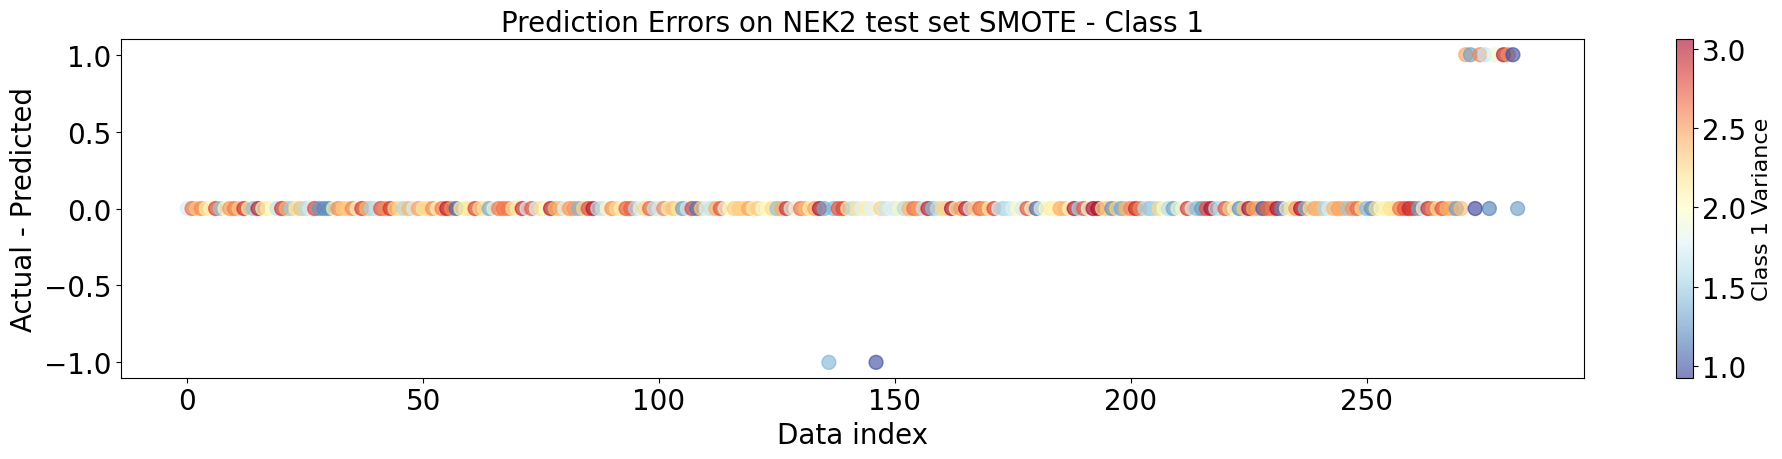

In [85]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 1",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [ ]:
test_pred_variance2D[1][0:2]

In [ ]:
test_pred_variance2D[0][0:2]

In [ ]:
# train_var = train_observed_pred.variance.numpy().tolist()
# plt.figure(figsize=(10, 6))
# for class_idx in range(2):
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')

# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.savefig('nek2train_hist.png')
# plt.show();


# plt.figure(figsize=(10, 6))
# for class_idx in range(2): 
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')
#     sns.violinplot(data=train_observed_pred.variance[class_idx].numpy().tolist(), inner="quartile")
# plt.xlabel('Class')

# plt.ylabel('Variance')
# plt.ylim(0,10)
# plt.legend()
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.grid(True)
# plt.show();

# plt.figure(figsize=(10, 6))
# for i in range(len(train_var)):
#     sns.kdeplot(train_var[i], label=f'Class {i}')
# plt.xlabel('Variance')
# plt.ylabel('Density')
# plt.title('KDE Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.show();

In [ ]:
# folds = [1] 
# for fold in folds: 
#     fold = str(fold)
#     trainx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainX.csv')
#     trainy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainY.csv')
#     testx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testX.csv')
#     testy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testY.csv')
#     # print(f'trainx :{trainx.shape}, trainy shape: {trainy.shape} \t testx: {testx.shape}, testy: {testy.shape}')
    
#     oversample_trial = SMOTE()
#     trial_train_x, trial_train_y_df = oversample_trial.fit_resample(trainx, trainy)
#     print(f'new trainx :{new_train_x_df.shape}, new trainy shape: {new_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'new trial trainx :{trial_train_x.shape}, new trial trainy shape: {trial_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'trial train same: {new_train_x_df.equals(trial_train_x)}')
#     print(f'test train same: {new_train_y_df.equals(trial_train_y_df)}')
#     print(f'trial test same: {test_x_df.equals(testx)}')
#     print(f'test test same: {test_y_df.equals(testy)}')
#     # print(list(new_train_x_df.values.flatten().tolist()))
#     # print(list(trial_train_x.values.flatten().tolist()))
#     diff_trainx = new_train_x_df.values != trial_train_x.values
#     which_diff_trainx = np.where(diff_trainx)
#     print(f"indices with differences in train x:", which_diff_trainx)
#     for i, val in enumerate(list(new_train_x_df.values.flatten().tolist())): 
#         other_val = list(trial_train_x.values.flatten().tolist())[i]
#         if (val != other_val): 
#             print(f'difference at index: {i}, new train y df: {val}, trial: {other_val}')
      
            